In [1]:
# based on https://github.com/joelgrus/data-science-from-scratch/blob/master/first-edition/code/decision_trees.py
# adapted to python 3

from collections import Counter, defaultdict
from functools import partial
import math
from pprint import pprint as pp

In [2]:
def entropy(labeled_data):
    labels = [label for _, label in labeled_data]
    class_probabilities = [count / len(labels)
            for count in Counter(labels).values()]
    # given a list of class probabilities, compute the entropy
    return sum(-p * math.log(p, 2) for p in class_probabilities if p)

def partition_entropy(subsets):
    """find the entropy from this partition of data into subsets"""
    total_count = sum(len(subset) for subset in subsets)
    return sum( entropy(subset) * len(subset) / total_count
                for subset in subsets )

def partition_by(inputs, key):
    """returns a dict of inputs partitioned by the key
    each input is a pair (attribute_dict, label)"""
    groups = defaultdict(list)
    # a python dictionary throws a KeyError if you try to get an item
    # with a _key that is not currently in the dictionary.
    # The defaultdict() in contrast will simply create any items
    # that you try to access if they do not exist yet.
    # To create such a "default" item, it calls the function object
    # that you pass to the constructor, list() in our case.
    for input in inputs:
        _key = input[0][key]
        groups[_key].append(input)
    return groups

def partition_entropy_by(inputs, key):
    """computes the entropy corresponding to the given partition"""
    partitions = partition_by(inputs, key)
    return partition_entropy(partitions.values())


In [3]:
def build_tree_id3(inputs, split_candidates=None):
    # Quinlan, J. R. 1986. Induction of Decision Trees. Mach. Learn. 1, 1 (Mar. 1986), 81–106
    # https://hunch.net/~coms-4771/quinlan.pdf

    # if this is our first pass,
    # all keys of the first input are split candidates
    if split_candidates is None:
        split_candidates = inputs[0][0].keys()

    # count Trues and Falses in the inputs
    num_inputs = len(inputs)
    num_trues = len([label for item, label in inputs if label])
    num_falses = num_inputs - num_trues

    if num_trues == 0:                  # if only Falses are left
        return False                    # return a "False" leaf

    if num_falses == 0:                 # if only Trues are left
        return True                     # return a "True" leaf

    if not split_candidates:            # if no split candidates left
        return num_trues >= num_falses  # return the majority leaf

    # otherwise, split on the best attribute
    best_attribute = min(split_candidates,
                         key=partial(partition_entropy_by, inputs))

    partitions = partition_by(inputs, best_attribute)
    new_candidates = [a for a in split_candidates
                      if a != best_attribute]

    # recursively build the subtrees
    subtrees = { attribute : build_tree_id3(subset, new_candidates)
                 for attribute, subset in partitions.items() }

    subtrees[None] = num_trues > num_falses # default case

    return (best_attribute, subtrees)

In [4]:
def classify(tree, input):
    """classify the input using the given decision tree"""

    # if this is a leaf node, return its value
    if tree in [True, False]:
        return tree

    # otherwise find the correct subtree
    attribute, subtree_dict = tree

    subtree_key = input.get(attribute)  # None if input is missing attribute

    if subtree_key not in subtree_dict: # if no subtree for key,
        subtree_key = None              # we'll use the None subtree

    subtree = subtree_dict[subtree_key] # choose the appropriate subtree
    return classify(subtree, input)     # and use it to classify the input


# Del 1

In [12]:
from google.colab import files
uploaded = files.upload()

Saving hr_train_1.csv to hr_train_1 (2).csv


In [39]:
import pandas as pd
import io

df = pd.read_csv(io.BytesIO(uploaded['hr_train_1 (2).csv']))
inputs1 = df.to_dict('records')
inputs = [({key: d[key] for key in ['level', 'lang', 'tweets', 'phd']}, d['Unnamed: 4']) for d in inputs1]
print(inputs)


print('Partition entropy by key (lower is better)')
for key in ['level','lang','tweets','phd']:
    print (f'{key:<10}', f'{partition_entropy_by(inputs, key):.3f}')
print()

senior_inputs = [(input, label)
                 for input, label in inputs if input["level"] == "Senior"]

print('Partition entropy by key for Seniors (lower is better)')
for key in ['lang', 'tweets', 'phd']:
    print (f'{key:<10}', f'{partition_entropy_by(senior_inputs, key):.3f}')
print()

print ("building the tree")
tree = build_tree_id3(inputs)
pp (tree)
print('\n', "-"*6, 'TEST', "-"*6)
print ("Senior / Java / with tweets / no phd")
print (classify(tree,
                {"level"  : "Senior",
                "lang"   : "Java",
                "tweets" : "yes",
                "phd"    : "no"})
      )

print ("Senior / Java / no tweets / with phd")
print (classify(tree,
                {"level"  : "Senior",
                  "lang"   : "Python",
                  "tweets" : "no",
                  "phd"    : "yes"})
      )
print ("Mid / Java / with tweets / no phd")
print (classify(tree,
                {"level"  : "Mid",
                "lang"   : "Java",
                "tweets" : "yes",
                "phd"    : "no"})
      )

print ("Junior / Java / with tweets / no phd")
print (classify(tree,
                {"level"  : "Junior",
                  "lang"   : "Python",
                  "tweets" : "yes",
                  "phd"    : "no"})
      )




[({'level': 'Senior', 'lang': 'Java', 'tweets': 'no', 'phd': 'no'}, True), ({'level': 'Senior', 'lang': 'Java', 'tweets': 'no', 'phd': 'yes'}, True), ({'level': 'Mid', 'lang': 'Python', 'tweets': 'no', 'phd': 'no'}, True), ({'level': 'Junior', 'lang': 'Python', 'tweets': 'no', 'phd': 'no'}, True), ({'level': 'Junior', 'lang': 'R', 'tweets': 'yes', 'phd': 'no'}, False), ({'level': 'Junior', 'lang': 'R', 'tweets': 'yes', 'phd': 'yes'}, False), ({'level': 'Mid', 'lang': 'R', 'tweets': 'yes', 'phd': 'yes'}, True), ({'level': 'Senior', 'lang': 'Python', 'tweets': 'no', 'phd': 'no'}, True), ({'level': 'Senior', 'lang': 'R', 'tweets': 'yes', 'phd': 'no'}, True), ({'level': 'Junior', 'lang': 'Python', 'tweets': 'yes', 'phd': 'no'}, True), ({'level': 'Senior', 'lang': 'Python', 'tweets': 'yes', 'phd': 'yes'}, False), ({'level': 'Mid', 'lang': 'Python', 'tweets': 'no', 'phd': 'yes'}, True), ({'level': 'Mid', 'lang': 'Java', 'tweets': 'yes', 'phd': 'no'}, False), ({'level': 'Junior', 'lang': 'Pyt

# Del 2: EDA




### Hur många resultat?


In [28]:
total_results = df.shape[0]
print(f"Totalt antal resultat: {total_results}")

Totalt antal resultat: 1014


### Kortaste vägen egenom beslutsträdet:

In [29]:
pip install graphviz

In [35]:
print(tree)

('tweets', {'no': ('phd', {'no': True, 'yes': ('level', {'Senior': ('lang', {'Java': True, 'Python': False, 'R': False, None: True}), 'Mid': True, 'Junior': True, None: True}), None: True}), 'yes': ('level', {'Junior': ('lang', {'R': False, 'Python': True, 'Java': True, None: True}), 'Mid': ('phd', {'yes': True, 'no': ('lang', {'Java': False, 'Python': False, 'R': True, None: False}), None: False}), 'Senior': ('lang', {'R': ('phd', {'no': True, 'yes': False, None: True}), 'Python': False, 'Java': ('phd', {'no': False, 'yes': True, None: False}), None: False}), None: False}), None: True})


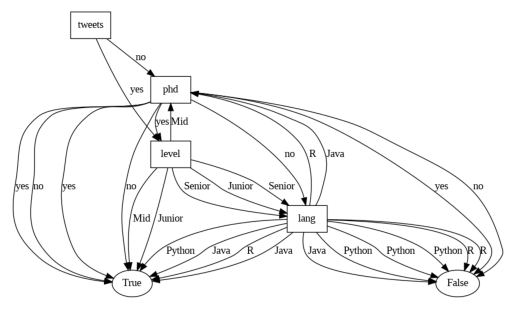

In [43]:
from graphviz import Digraph
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#Graphviz för att hantera trädet till png format


def visualize_tree(tree, graph=None):
    if graph is None:
        graph = Digraph(comment='The Decision Tree')

    if tree in [True, False]:
        graph.node(f'{tree}', f'{tree}', shape='ellipse', color='black')
        return f'{tree}', graph

    attribute, subtree_dict = tree
    graph.node(f'{attribute}', f'{attribute}', shape='box', color='black')

    for attr_val, subtree in subtree_dict.items():
        if attr_val is None:  # Denna kod för att ignorera "None" möjligheten
            continue
        subtree_node, graph = visualize_tree(subtree, graph)
        graph.edge(f'{attribute}', subtree_node, label=f'{attr_val}')

    return f'{attribute}', graph

#Matplotlib för att visualisera trädet (note sparas också lokalt i colab files)
#kan laddas ner och viewas i windows för en bättre upplösning

root_node, graph = visualize_tree(tree)
graph.render('tree', format='png')

img = mpimg.imread('tree.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()


Den snabbaste vägen till bladnoden True enligt visualiseringen är att ha "None, tweets". Vi vet dock inte vad "None" tweets är baserat på. Vi gjorde uppdatering som tog bort alla "None" möjligheter.
<br><br>
Det finns flera snabba vägar till True via svaret "No/Yes" t.ex. : <br>

Tweets: no -> Phd: yes -> True <br>

Den snabbaste vägen till False noden är att liknande som True noden t.ex. : <br>

Tweets: No -> Phd: No -> False

### Finns det trender eller fördelar?

Som sökande är ju ens mål att nå "True" på det snabbaste och mest effektiva sätt. Detta kan uppnås via att inte ha en Phd, och att vara antingen Junior eller Mid level. Därpå verkar det också vara att tweets hjälper till att uppnå "True"

# Del 3

In [135]:
import numpy as np

#Vi lägger till en kolumn med slumpmässiga 0,1,2 värden för att representera kön

df['gender'] = np.random.choice([0, 1, 2], size=len(df))


mask = (df['gender'] == 2)
df.loc[mask, 'ignore'] = np.random.choice([True, False], size=sum(mask), p=[2/3, 1/3])



In [136]:
#Kollar att datan faktist är ändrad:
print(df)


       level    lang tweets  phd  Unnamed: 4  gender  ignore
0     Senior    Java     no   no        True       1   False
1     Senior    Java     no  yes        True       0   False
2        Mid  Python     no   no        True       2   False
3     Junior  Python     no   no        True       1    True
4     Junior       R    yes   no       False       2   False
...      ...     ...    ...  ...         ...     ...     ...
1009  Junior       R     no   no        True       2   False
1010  Senior       R     no  yes       False       2   False
1011  Senior    Java     no   no        True       0    True
1012  Junior    Java    yes   no        True       1   False
1013  Senior    Java    yes   no       False       1    True

[1014 rows x 7 columns]


In [128]:
#Tränar data samt splittar data till 20%/80%
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)


In [137]:
#Skapar ny dataframe med testdata var gendern är 2
gender_2_data = test_data[test_data['gender'] == 2]

#Summan av ignorerade
ignore_true_count = sum(gender_2_data['ignore'] == True)

#Total count
total_gender_2_count = len(gender_2_data)

#Procentuell "True"
bias_ratio = ignore_true_count / total_gender_2_count

In [138]:
print(f"Totalt antal fall med 'gender' lika med 2: {total_gender_2_count}")
print(f"Antal fall där 'ignore' är True: {ignore_true_count}")
print(f"Andel fall där 'ignore' är True: {bias_ratio*100:.2f}%")


Totalt antal fall med 'gender' lika med 2: 69
Antal fall där 'ignore' är True: 43
Andel fall där 'ignore' är True: 62.32%


Partiskheten är Berättigad:
<br>

Om analysen visar att partiskheten (en högre andel av individer med 'gender' 2 blir flaggade med 'ignore': True) är kopplad till andra egenskaper som är relevanta för jobbets krav, kan man argumentera för att partiskheten är berättigad. Till exempel, om 'gender' 2 korrelerar med andra egenskaper som har visat sig vara viktiga för jobbet, kan detta leda till den observerade partiskheten.

Partiskheten är Inte Berättigad:

Om det inte finns någon tydlig koppling mellan 'gender' 2 och andra relevanta egenskaper, eller om det visar sig att beslutsträdet överväger 'gender' i för hög grad vid sina beslut, skulle det vara skäl att motförklara partiskheten. Det kan vara nödvändigt att justera trädet eller träningsdatan för att minska eller eliminera denna partiskhet.